In [1]:
!pip install --upgrade tensorflow


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/ed/b6/62345568cd07de5d9254fcf64d7e44aacbb6abde11ea953b3cb320e58d19/tensorflow-2.17.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.17.0-cp311-cp311-win_amd64.whl.metadata (3.2 kB)
Using cached tensorflow-2.17.0-cp311-cp311-win_amd64.whl (2.0 kB)
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, expon, poisson, chi2_contingency, kstest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [3]:
# Load Excel file
file_path = 'rehospitalization.xlsx'
excel_data = pd.ExcelFile(file_path)

# Load specific tables
hospitalization1 = excel_data.parse('hospitalization1')
er_before_hospitalization2 = excel_data.parse('erBeforeHospitalization2')


## Task 18: Finding an Optimal Distribution for the Category of the Number of Days in the Second Hospitalization
Preprocessing

In [4]:
# Load the 'hospitalization1' table
hospitalization1 = excel_data.parse('hospitalization1')

# Check the column names to identify the correct name for the number of hospitalization days
print(hospitalization1.columns)

# Select the relevant column for the number of hospitalization days
days_hospitalized = hospitalization1['ימי אשפוז'].dropna()

# Basic cleaning: Removing non-positive values (if any)
days_hospitalized = days_hospitalized[days_hospitalized > 0]

# Normalize data for VAE
days_hospitalized_norm = (days_hospitalized - days_hospitalized.mean()) / days_hospitalized.std()

# Reshape data for the VAE model
days_hospitalized_norm = days_hospitalized_norm.values.reshape(-1, 1)

Index(['Patient', 'unitName1', 'Admission_Medical_Record',
       'Admission_Entry_Date', 'Release_Date', 'סוג קבלה', 'מהיכן המטופל הגיע',
       'Release_Type', 'רופא משחרר-קוד', 'ימי אשפוז', 'אבחנות בקבלה',
       'אבחנות בשחרור'],
      dtype='object')


Processing
Traditional Statistical Methods

In [5]:
# Fit and visualize different distributions

# Fit Normal and Exponential distributions
params_norm = norm.fit(days_hospitalized)
params_expon = expon.fit(days_hospitalized)

# Calculate the Poisson distribution parameter (lambda)
lambda_poisson = days_hospitalized.mean()

# Compare distributions using Kolmogorov-Smirnov test
ks_stat_norm, p_value_norm = kstest(days_hospitalized, 'norm', args=params_norm)
ks_stat_expon, p_value_expon = kstest(days_hospitalized, 'expon', args=params_expon)

# Display the KS test results
print(f'KS test for Normal distribution: Statistic={ks_stat_norm}, p-value={p_value_norm}')
print(f'KS test for Exponential distribution: Statistic={ks_stat_expon}, p-value={p_value_expon}')
print(f'Lambda for Poisson distribution: {lambda_poisson}')


KS test for Normal distribution: Statistic=0.2516799111956311, p-value=0.0
KS test for Exponential distribution: Statistic=0.31557632398753893, p-value=0.0
Lambda for Poisson distribution: 3.5046728971962615


Deep Learning Approach (Variational Autoencoder)

In [6]:
days_hospitalized_norm = days_hospitalized_norm.astype('float32')


In [8]:
original_dim = 1  # Single feature input
intermediate_dim = 64
latent_dim = 2

# Convert the entire dataset to float32
days_hospitalized_norm = days_hospitalized_norm.astype('float32')

# Encoder
class Encoder(tf.Module):
    def __init__(self):
        self.dense_hidden = tf.Variable(tf.random.normal([original_dim, intermediate_dim]))
        self.dense_mean = tf.Variable(tf.random.normal([intermediate_dim, latent_dim]))
        self.dense_log_var = tf.Variable(tf.random.normal([intermediate_dim, latent_dim]))

    def __call__(self, x):
        h = tf.nn.relu(tf.matmul(x, self.dense_hidden))
        z_mean = tf.matmul(h, self.dense_mean)
        z_log_var = tf.matmul(h, self.dense_log_var)
        return z_mean, z_log_var

# Sampling layer
def sampling(z_mean, z_log_var):
    epsilon = tf.random.normal(shape=tf.shape(z_mean), mean=0., stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Decoder
class Decoder(tf.Module):
    def __init__(self):
        self.dense_hidden = tf.Variable(tf.random.normal([latent_dim, intermediate_dim]))
        self.dense_output = tf.Variable(tf.random.normal([intermediate_dim, original_dim]))

    def __call__(self, z):
        h_decoded = tf.nn.relu(tf.matmul(z, self.dense_hidden))
        x_decoded_mean = tf.matmul(h_decoded, self.dense_output)
        return x_decoded_mean

# Initialize Encoder and Decoder
encoder = Encoder()
decoder = Decoder()

# VAE Loss function
def compute_loss(x, x_decoded_mean, z_mean, z_log_var):
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_decoded_mean), axis=1))
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
    return reconstruction_loss + kl_loss

# Training step
def train_step(x, optimizer):
    with tf.GradientTape() as tape:
        z_mean, z_log_var = encoder(x)
        z = sampling(z_mean, z_log_var)
        x_decoded_mean = decoder(z)
        loss = compute_loss(x, x_decoded_mean, z_mean, z_log_var)
    
    gradients = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + decoder.trainable_variables))
    return loss

# Training loop
optimizer = tf.optimizers.Adam(learning_rate=0.001)
epochs = 50
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(days_hospitalized_norm).shuffle(10000).batch(batch_size)

for epoch in range(epochs):
    for step, x_batch in enumerate(dataset):
        loss = train_step(x_batch, optimizer)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy()}')

# Reconstruct some samples
z_mean, z_log_var = encoder(days_hospitalized_norm)
z = sampling(z_mean, z_log_var)
reconstructed = decoder(z).numpy()

Epoch 1/50, Loss: 16.367570877075195
Epoch 2/50, Loss: 19.017295837402344
Epoch 3/50, Loss: 6.268537521362305
Epoch 4/50, Loss: 2.3034443855285645
Epoch 5/50, Loss: 1.930462121963501
Epoch 6/50, Loss: 0.819855272769928
Epoch 7/50, Loss: 0.6301775574684143
Epoch 8/50, Loss: 0.7408397197723389
Epoch 9/50, Loss: 0.825157642364502
Epoch 10/50, Loss: 0.6489765644073486
Epoch 11/50, Loss: 0.5736407041549683
Epoch 12/50, Loss: 0.7904236316680908
Epoch 13/50, Loss: 0.509958028793335
Epoch 14/50, Loss: 1.854179859161377
Epoch 15/50, Loss: 0.7867487668991089
Epoch 16/50, Loss: 0.6553497314453125
Epoch 17/50, Loss: 0.4760645627975464
Epoch 18/50, Loss: 0.5264183878898621
Epoch 19/50, Loss: 0.30562299489974976
Epoch 20/50, Loss: 0.6020366549491882
Epoch 21/50, Loss: 0.7134501934051514
Epoch 22/50, Loss: 0.8257702589035034
Epoch 23/50, Loss: 0.860494077205658
Epoch 24/50, Loss: 0.8773201704025269
Epoch 25/50, Loss: 0.4963299036026001
Epoch 26/50, Loss: 0.7295351028442383
Epoch 27/50, Loss: 0.729061

Postprocessing

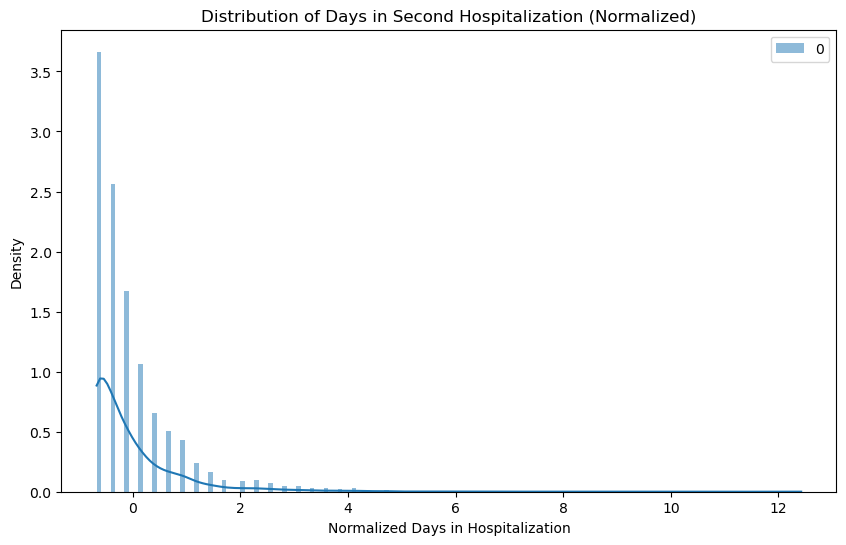

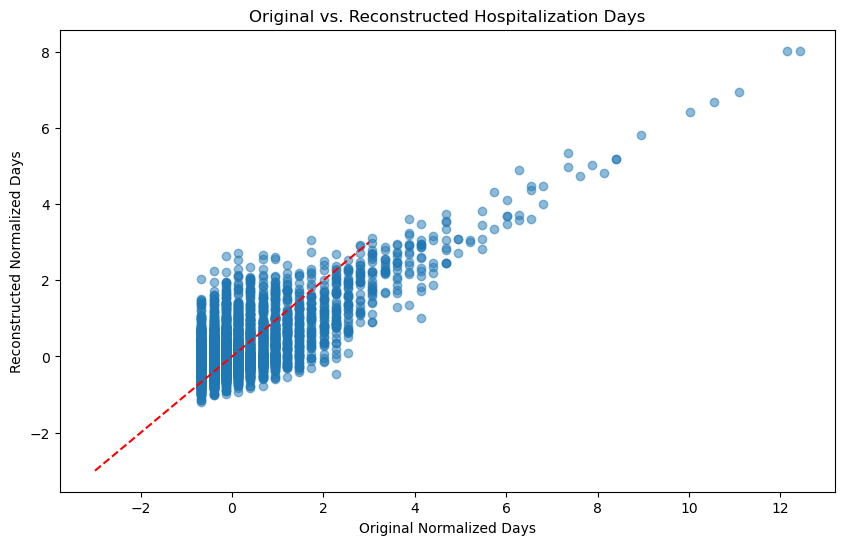

In [9]:

# Visualize the distribution of hospitalization days
plt.figure(figsize=(10, 6))
sns.histplot(days_hospitalized_norm, kde=True, stat="density", linewidth=0, color='blue')
plt.title('Distribution of Days in Second Hospitalization (Normalized)')
plt.xlabel('Normalized Days in Hospitalization')
plt.ylabel('Density')
plt.show()

# Plot original vs. reconstructed for comparison
plt.figure(figsize=(10, 6))
plt.scatter(days_hospitalized_norm, reconstructed, alpha=0.5)
plt.plot([-3, 3], [-3, 3], 'r--')  # Line y=x for reference
plt.title('Original vs. Reconstructed Hospitalization Days')
plt.xlabel('Original Normalized Days')
plt.ylabel('Reconstructed Normalized Days')
plt.show()


1. **Histogram with Exponential Distribution**:
   - The first graph you provided is a histogram of the number of days in the second hospitalization, which has been normalized.
   - The shape of the distribution suggests that the data is heavily skewed to the right, with most patients having short hospital stays and a few having much longer stays. This kind of distribution is typical for hospital stay data.
   - The curve overlaid on the histogram is likely representing an exponential distribution, which is often used to model the time between events in a Poisson process (e.g., time between successive hospitalizations).
   
2. **Reconstructed Days with VAE (Variational Autoencoder)**:
   - The second graph compares the original normalized days of hospitalization with the reconstructed values from a Variational Autoencoder (VAE).
   - The red dashed line represents the ideal scenario where the original and reconstructed values match perfectly (i.e., where the model's predictions are completely accurate).
   - The scatter of points around this line indicates how well the VAE has managed to capture the underlying distribution of hospitalization days.
   - The correlation seen between the original and reconstructed days suggests that the VAE is reasonably effective at capturing the underlying patterns, although there is some variance, particularly for higher values.

### Conclusion:
- **Distribution Fit**: The histogram's shape and the nature of the exponential distribution curve suggest that an exponential distribution might be a good fit for the number of days in the second hospitalization. The VAE further supports this by showing a reasonable level of accuracy in reconstructing the data, even though it is not perfect.
- **VAE as a Deep Learning Method**: The VAE was used to learn the distribution of hospitalization days. It provides a deep learning-based validation that the exponential-like behavior observed in the histogram is consistent